#This notebook uses ECG200 data and perform classification using two different methods: Recurrence plots(RP) and Gramian Angular Field (GAF).

Same notebook can be slightly modified to run for 50words

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys,os
from mpl_toolkits.axes_grid1 import make_axes_locatable

#series2RP

In [0]:
#unthresholded recurrence plot
def r_plot(data,delay=0):
    transformed=np.zeros([2,len(data)-delay])
    transformed[0,:]=data[0:len(data)-delay]
    transformed[1,:]=data[delay:len(data)]
    rp=np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        for j in range(len(rp)):
            rp[i,j]=np.linalg.norm(transformed[:,i]-transformed[:,j])
    return np.array(rp.flatten())

In [4]:
def paa(series, now, opw):
    if now == None:
        now = int(len(series) / opw)
    if opw == None:
        opw = int(len(series) / now)
    return [sum(series[i * opw : (i + 1) * opw]) / float(opw) for i in range(now)]
datafiles = ['ECG200_TRAIN', 'ECG200_TEST',] # Data file name
rplot = [[],[]]
labels = [[],[]]
phase_space_vector = [0,0]
size=[31]
for i in range(len(datafiles)):
    fn = datafiles[i]
    for s in size:  
        print('read file: {}, size: {}'.format(datafiles[i], s))
        #read data
        raw = open('/content/drive/Shared drives/AML Project Fall 2019/ECG200/'+fn+'.tsv').readlines()
        raw = [list(map(float, each.strip().split('\t'))) for each in raw]

        for each in raw:
            labels[i].append(each[0])
            paa_data = np.array(paa(each[1:],s,None))
            smt= r_plot(paa_data)
            rplot[i].append(smt)
        phase_space_vector[i] = (np.asarray(rplot[i]),labels[i]) 



read file: ECG200_TRAIN, size: 31
read file: ECG200_TEST, size: 31


In [0]:
ECG200_TRAIN_phasespace= phase_space_vector[0]
ECG200_TEST_phasespace= phase_space_vector[1]

In [0]:
train_img= ECG200_TRAIN_phasespace[0]
test_img= ECG200_TEST_phasespace[0]
train_labels= ECG200_TRAIN_phasespace[1]
test_labels= ECG200_TEST_phasespace[1]
for i in range(ECG200_TRAIN_phasespace[0].shape[0]):
  if train_labels[i] == -1:
    train_labels[i]=0
for i in range(ECG200_TEST_phasespace[0].shape[0]):
  if test_labels[i] == -1:
    test_labels[i]=0

In [7]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model
from keras import optimizers
batch_size =10
num_classes = 2
epochs = 500

# input image dimensions
img_rows, img_cols = 31,31
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = (train_img, train_labels), (test_img, test_labels)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
def labeling(y,num_classes):
  from sklearn.preprocessing import LabelEncoder
  encoder = LabelEncoder()
  encoder.fit(y)
  encoded_Y = encoder.transform(y)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = keras.utils.np_utils.to_categorical(encoded_Y,num_classes)
  return(dummy_y)

#from keras.utils.np_utils import to_categorical
#one-hot encode target column
y_train = labeling(y_train, num_classes)
y_test = labeling(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3,3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history=model.fit(x_train, y_train,
          batch_size,
          epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Using TensorFlow backend.


x_train shape: (100, 31, 31, 1)
100 train samples
100 test samples





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 100 samples, validate on 100 samples
Epoch 1/500





100/100 [==============================] - 1s 14ms/step - loss: 0.6752 - acc: 0.6300 - val_loss: 0.6662 - val_acc: 0.6400
Epoch 2/500
100/100 [==============================] - 0s 2ms/step - loss: 0.6257 - acc: 0.6900 - val_loss: 0.6629 - val_acc: 0.6400
Epoch 3/500
100/100 [==============================] - 0s 2ms/step - loss: 0.6373 - acc: 0.6900 - val_loss: 0.6502 - val_acc: 0.6400
Epoch 4/500
100/100 [==============================] - 0s 2ms/step - loss: 0.6204 - acc: 0.6900 - val_loss: 0.6550 - val_acc: 0.6400
Epoch 5/500
100/100 [==============================] - 0s 3ms/step - loss: 0.6389 - acc: 0.6900 - val_loss: 0.6485 - val_acc: 0.64

#RP 31x31

In [8]:
print(max(history.history['val_acc']))
print(max(history.history['acc']))

0.95
1.0


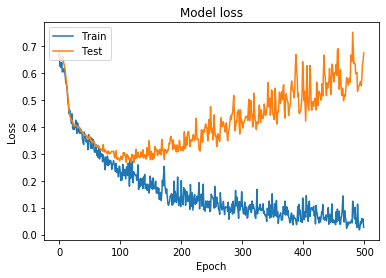

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

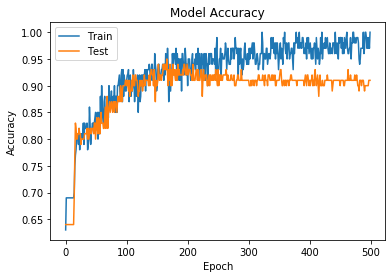

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# seires2GAF

read file: ECG200_TRAIN, size: 31, GAF type: GADF, rescale_type: Zero
format data
read file: ECG200_TEST, size: 31, GAF type: GADF, rescale_type: Zero
format data


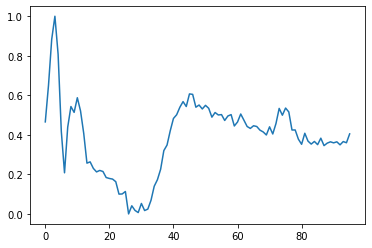

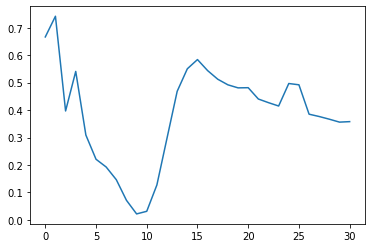

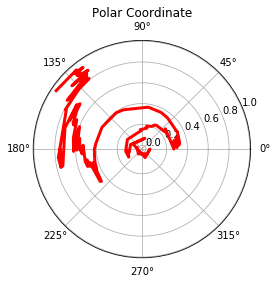

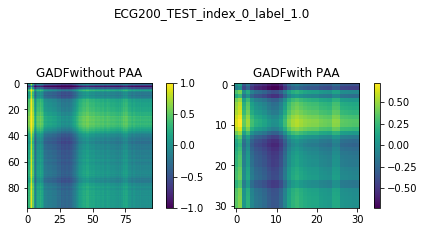

In [3]:

#PAA function -- dimensionality reduction
def paa(series, now, opw):
    if now == None:
        now = int(len(series) / opw)
    if opw == None:
        opw = int(len(series) / now)
    return [sum(series[i * opw : (i + 1) * opw]) / float(opw) for i in range(now)]

#Rescale data into [0,1]
def rescale(serie):
    maxval = max(serie)
    minval = min(serie)
    gap = float(maxval-minval)
    return [(each-minval)/gap for each in serie]
#Rescale data into [-1,1]    
def rescaleminus(serie):
    maxval = max(serie)
    minval = min(serie)
    gap = float(maxval-minval)
    return [(each-minval)/gap*2-1 for each in serie]

    
#################################
###Define the parameters here####
#################################

datafiles = ['ECG200_TRAIN', 'ECG200_TEST',] # Data file name
size = [31]  # PAA size
GAF_type = 'GADF' # GAF type: GASF, GADF
save_PAA = True # Save the GAF with or without dimension reduction by PAA: True, False
rescale_type = 'Zero' # Rescale the data into [0,1] or [-1,1]: Zero, Minusone 
polarvectors= [0,0]


for i in range(len(datafiles)):
    fn = datafiles[i]
    for s in size:  
        print('read file: {}, size: {}, GAF type: {}, rescale_type: {}'.format(datafiles[i], s, GAF_type, rescale_type))
        #read data
        raw = open('/content/drive/Shared drives/AML Project Fall 2019/ECG200/'+fn+'.tsv').readlines()
        raw = [list(map(float, each.strip().split('\t'))) for each in raw]
        length = len(raw[0])-1
        
        print('format data')
        label = []
        image = []
        paaimage = []
        #patchimage = []
        matmatrix = []
        fullmatrix = []
        data1 =[]  #time series data collection
        paadata1 = [] #after paa time series data collection
        for each in raw:
            label.append(each[0])
            if rescale_type == 'Zero':
                std_data = rescale(each[1:])
            elif rescale_type == 'Minusone':
                std_data = rescaleminus(each[1:])
            else:
                sys.exit('Unknown rescaling type!')
            paalistcos = paa(std_data,s,None)            
            datacos = np.array(std_data)
            data1.append(datacos)
            datasin = np.sqrt(1-np.array(std_data)**2)

            paalistcos = np.array(paalistcos)
            paadata1.append(paalistcos)
            paalistsin = np.sqrt(1-paalistcos**2)
            
            datacos = np.matrix(datacos)
            datasin = np.matrix(datasin)            
            
            paalistcos = np.matrix(paalistcos)
            paalistsin = np.matrix(paalistsin)            
            if GAF_type == 'GASF':
                paamatrix = paalistcos.T*paalistcos-paalistsin.T*paalistsin
                matrix = np.array(datacos.T*datacos-datasin.T*datasin)
            elif GAF_type == 'GADF':
                paamatrix = paalistsin.T*paalistcos-paalistcos.T*paalistsin
                matrix = np.array(datasin.T*datacos - datacos.T*datasin)
            else:
                sys.exit('Unknown GAF type!')
            paamatrix = np.array(paamatrix)
            image.append(matrix)
            paaimage.append(np.array(paamatrix))
            matmatrix.append(paamatrix.flatten())
            fullmatrix.append(matrix.flatten())
    
        label = np.asarray(label)
        image = np.asarray(image)
        paaimage = np.asarray(paaimage)
        matmatrix = np.asarray(matmatrix)
        fullmatrix = np.asarray(fullmatrix)

        if save_PAA == True:        
            finalmatrix = matmatrix
        else:
            finalmatrix = fullmatrix
        polarvectors[i]= (finalmatrix, label)

k=0
fig = plt.figure()
ax = plt.axes()
ax.plot(data1[k]);

fig = plt.figure()
ax = plt.axes()
ax.plot(paadata1[k]);

# polar coordinates
k=0;r = np.array(range(1,length+1));r=r/100.0;theta = np.array(rescale(raw[k][1:]))*2*np.pi;plt.figure();ax = plt.subplot(polar=True);ax.set_title('Polar Coordinate',y=1.08);ax.plot(theta, r, color='r', linewidth=3);plt.show()
## draw large image and paa image
k = 0;plt.figure();plt.suptitle(datafiles[i]+'_index_'+str(k)+'_label_'+str(label[k]));ax1 = plt.subplot(121);plt.title(GAF_type + 'without PAA');plt.imshow(image[k]);divider = make_axes_locatable(ax1);cax = divider.append_axes("right", size="5%", pad=0.2);plt.colorbar(cax = cax);ax2 = plt.subplot(122);plt.title(GAF_type + 'with PAA');plt.imshow(paaimage[k]);divider = make_axes_locatable(ax2);cax = divider.append_axes("right", size="5%", pad=0.2);plt.colorbar(cax = cax);plt.tight_layout()

In [0]:
ECG200_TRAIN_polar=polarvectors[0]
ECG200_TEST_polar=polarvectors[1]

In [0]:
train_img= ECG200_TRAIN_polar[0]
test_img= ECG200_TEST_polar[0]
train_labels= ECG200_TRAIN_polar[1]
test_labels= ECG200_TEST_polar[1]
for i in range(ECG200_TRAIN_polar[0].shape[0]):
  if train_labels[i] == -1:
    train_labels[i]=0
for i in range(ECG200_TEST_polar[0].shape[0]):
  if test_labels[i] == -1:
    test_labels[i]=0

In [6]:
#Convolution Neural Network

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model
from keras import optimizers

size= 32
batch_size =10
num_classes = 2
epochs = 4500

# input image dimensions
img_rows, img_cols = size-1, size-1
(x_train, y_train), (x_test, y_test) = (train_img, train_labels), (test_img, test_labels)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
  
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0))
model.add(Dense(num_classes, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])
train_loss = []
test_loss = []
for i in range(1):
  history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
  score_train=model.evaluate(x_train,y_train,verbose=0)
  score = model.evaluate(x_test, y_test, verbose=0)
  train_loss.append(score_train[0])
  #print(score_train[0])
  test_loss.append(score[0])
  #print(score[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (100, 31, 31, 1)
100 train samples
100 test samples






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 100 samples, validate on 100 samples
Epoch 1/4500





100/100 [==============================] - 8s 75ms/step - loss: 0.6890 - acc: 0.6200 - val_loss: 0.6846 - val_acc: 0.6400
Epoch 2/4500
100/100 [==============================] - 0s 540us/step - loss: 0.6738 - acc: 0.6900 - val_loss: 0.6707 - val_acc: 0.6400
Epoch 3/4500
100/100 [==============================] - 0s 521us/step - loss: 0.6550 - acc: 0.6900 - val_loss: 0.6589 - val_acc: 0.6400
Epoch 4/4500
100/100 [==============================] - 0s 569us/step - loss: 0.6355 - acc: 0.6900 - val_loss: 0.6537 - val_acc: 0.6400
Epoch 5/4500
100/100 [==============================] - 0s 570us/step - loss: 0.6253 - acc: 0.6900 - val_loss: 0.6545 - val_acc: 0.6400
Epoch 6/4500
100/100 [==============================] - 0s 553us/step - loss: 0.6209 - acc: 0.6900 -

#GADF 31x31


In [7]:
print(max(history.history['val_acc']))
print(max(history.history['acc']))

0.8899999916553497
1.0


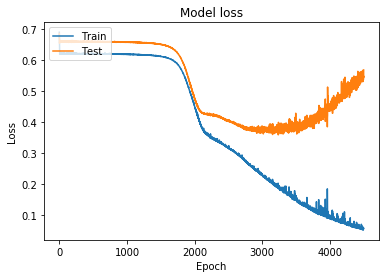

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

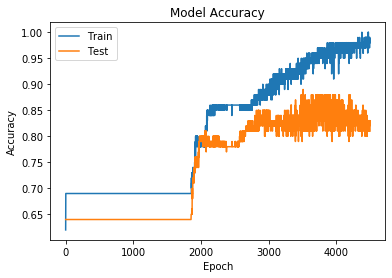

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()